##Preprocessing the Data

In [0]:
import fastai
from fastai.text import *

In [0]:
folder = '.'
url = 'https://raw.githubusercontent.com/micklwl/cs3244/master/dataset.csv'
train = pd.read_csv(url, sep =',')

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
train[['Insult', 'Comment']].to_csv('train_final.csv', index=None, header=True)

In [0]:
# Local data
test = pd.read_csv('../content/gdrive/My Drive/CS3244 Project/Local Data - Sheet1.csv')
local_train = pd.read_csv('../content/gdrive/My Drive/CS3244 Project/Local Training Data.csv')

In [0]:
#Convert contractions
def preprocess(dataset):
  dataset["Comment"] = dataset["Comment"].str.replace("can't","can not")
  dataset["Comment"] = dataset["Comment"].str.replace("you're","you are")
  dataset["Comment"] = dataset["Comment"].str.replace("don't","do not")
  dataset["Comment"] = dataset["Comment"].str.replace("i'm","i am")

  return dataset

In [0]:
preprocess(test)
preprocess(train)

,Insult,Comment
0,0,Sad truth is there are more hot girls than suc...
1,1,"To the author, you should just contract covid ..."
2,0,Aiyo it's just diff cultures la..china men are...
3,0,Korean oppa seem to cry alot too. Maybe he tho...
4,0,Guess all the mid range height population are ...
...,...,...
295,0,Yes. You will need to wear a mask.
296,1,"Kbkb, erection still retain power. You guys re..."
297,1,TS do not need brain if not using right?
298,1,Circuit breaker really accelerate their mental...


In [0]:
test[['Insult','Comment']].to_csv('test.csv', index=None, header=True)

In [0]:
# Local Data
test_file = 'test.csv'

In [0]:
# For the language model
pd.concat([train['Comment'], local_train['Comment']]).to_csv('unlabeled_comments.csv', index=None, header=True)

In [0]:
folder = '.'
unlabeled_file = 'unlabeled_comments.csv'

In [0]:
bs,bptt=32,80

##Fine-tuning the Language Model

In [0]:
# Tokenize data for the language model
data_lm = TextLMDataBunch.from_csv(folder, unlabeled_file, text_cols='Comment')

In [0]:
# Saves the data, so that when the notebook is restarted, 
# we don't have to run data_lm again
data_lm.save('data_lm.pkl')

In [0]:
# Loads data
data_lm = load_data(folder, 'data_lm.pkl', bs=bs, bptt=bptt)

In [0]:
data_lm.show_batch()

idx,text
0,cite a source specifically saying the site has been abandoned i do not believe such a source exists right now we have the kickstarter as a source stating that he plans to continue goats this contradicts any notions abandonment are we actually arguing about this if you have a gripe about the rosenberg discontinuing goats then here is not the place for it xxunk xxbos how good pussy taste i
1,ignored but others taken up with relish so i pose the question if an active arbitrator admitted that they are a right wing pov xxunk who has in real life even acted in such a way as to have been suspended from practicing law are they fit to continue in their post and meet out judgements on others xxunk xxunk 0129 2004 dec 18 omitted sig added request for arbitration
2,yes kay i had to 1 teach myself digital electronics and 2 design and create the board to interface to these xxunk xxunk ex type a char on the selectric terminal and watch what came in on an xxunk then program the altair to produce outputs that matched that timing learning that gasp ibm put the parity bit at the opposite end of the word than most of the rest
3,longer range part seems more important that is sort of tied to what s is in the 3rd lead paragraph now as well that covers every major thing in the article xxbos i should say i have never even heard of them xxbos xxunk chapin hi not sure this is the place to reply to your email i am the sponsor of the commission you indicated you needed a source
4,2006 utc xxunk if you really want all the nitty gritty information of xxunk case then why do not you do what was suggested at the start of this debate and do a full court record of xxunk trial this is an article about gary glitter the singer while it will of course mention details about the case it is not a case of doing it to the degree that


In [0]:
# Create the language model using the tokenized data
learn = language_model_learner(data_lm, AWD_LSTM)

In [0]:
# Finds the best learning rate for fine-tuning the language model
%%time
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
CPU times: user 10.3 s, sys: 6.05 s, total: 16.4 s
Wall time: 16.6 s


Min numerical gradient: 3.98E-02
Min loss divided by 10: 1.00E-02


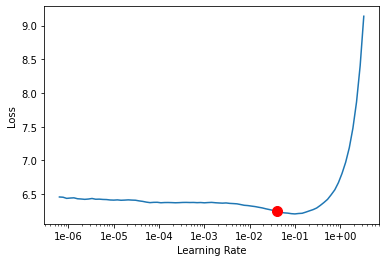

In [0]:
learn.recorder.plot(suggestion=True)

In [0]:
# Retrieves the best learning rate for the language model
best_lm_lr = learn.recorder.min_grad_lr
best_lm_lr

0.03981071705534969

In [0]:
# Learning with Discriminative fine-tuning and gradual unfreezing
learn.fit_one_cycle(1, best_lm_lr, moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,5.430110,5.037243,0.215932,09:40


In [0]:
learn.unfreeze()

In [0]:
%%time
learn.fit_one_cycle(1, best_lm_lr/10, moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,4.844497,4.646588,0.258311,09:39


CPU times: user 6min 4s, sys: 3min 30s, total: 9min 34s
Wall time: 9min 39s


In [0]:
# Save encode Object
learn.save_encoder('fwd_enc')

In [0]:
# check how the language model performs
learn.predict('fuck you', n_words=10)

'fuck you jesus love i i man y xxbos it doing keep'

##Fine-tuning the Classifier

In [0]:
train_file = 'train_final.csv'

In [0]:
# Create Classification Data
data_clas = TextClasDataBunch.from_csv(path=folder, 
                                        csv_name=train_file,
                                        vocab=data_lm.train_ds.vocab, 
                                        bs=32,
                                        text_cols='Comment', 
                                        label_cols='Insult')

In [0]:
# Save the data
data_clas.save('data_clas.pkl')

In [0]:
# Load the data
data_clas = load_data(folder, 'data_clas.pkl', bs=bs)

In [0]:
data_clas.show_batch()

text,target
xxbos henry xxunk democrat us secretary of housing and urban development from 1993 to 1997 pleaded guilty to a misdemeanor charge of lying to the xxunk a xxunk jr democrat member of house of representatives from ohio expelled from congress after being convicted of corruption charges sentenced today to eight years in prison for accepting bribes and kickbacks john doug xxunk democrat member of kentucky state senate from 1980 to,0
xxbos xxunk is a friggen xxunk xxunk is a friggen xxunk xxunk is a friggen xxunk xxunk is a friggen xxunk xxunk i am not a vandal this is not a macro your account has been xxunk xxunk is a friggen xxunk xxunk is a friggen xxunk xxunk is a friggen xxunk xxunk is a friggen xxunk xxunk i am not a vandal this is not a macro your account,1
xxbos the starting point is near xxunk in exodus xxunk was one of a pair of treasure cities or xxunk and the first station of the exodus in the story there are two treasure cities xxunk in the delta and ra xxunk ses at xxunk egypt exodus 1714 and the children of israel were fruitful and increased abundantly and multiplied and xxunk exceeding mighty and the land was filled with,0
xxbos verifiability i noticed you deleted all of my contribution yet again it would be more helpful not to mention a show of good faith if you would participate in the process and edit my contributions instead of completely deleting them now that you have removed the link to the powerbasic forums and elected to not sanction the description of official powerbasic forum perhaps some other relevant links would be,0
xxbos i am pleased that others have joined this enquiry but i am already dismayed to find that someone has found it necessary to sweep the jewish question under the carpet when reference on this talk page had already been made to one incident involving a final solution of the jews in england i like those terms because they shock the conscience in that everyone knows what those terms mean,0


In [0]:
# Creating Classifier Object
learn_clas = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, pretrained=False)

# Add weights of fine-tuned language model 
learn_clas.load_encoder('fwd_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (134654 items)
x: TextList
xxbos haha a black kid was shot by a hispanic and you still find a way to blame whitey your ignorance is astounding,xxbos considering that as francisco xxunk says the fascist international decided not to invest its time and funds in romania as early as the late 1930s they probably did p,xxbos preceding unsigned comment added by xxunk,xxbos i ve nominated this series of articles for dyk recently the created m of xxunk if you have alternative suggestions about the hook or any ideas for a picture i am always open to your ideas,xxbos not everyone some people turn up trying to find out about the sport i just can not see how the table will work if the leading driver scores less points than the runnerup enna
y: CategoryList
1,0,0,0,0
Path: .;

Valid: LabelList (33664 items)
x: TextList
xxbos it says under admissions requirements that men must have one testicle i looked at west points website and could nt find anyt

In [0]:
# Find the best learning rate for the classifier
learn_clas.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.00E-01
Min loss divided by 10: 3.63E-02


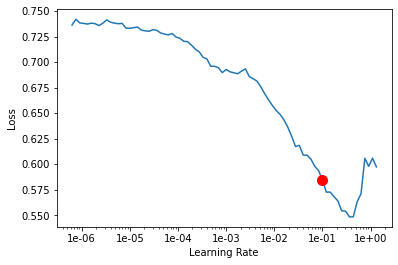

In [0]:
learn_clas.recorder.plot(suggestion=True)

In [0]:
# Retrieve the best learning rate for classifier
best_clf_lr = learn_clas.recorder.min_grad_lr
best_clf_lr

0.09999999999999999

In [0]:
# Fitting Classifier Object
learn_clas.fit_one_cycle(1, best_clf_lr, moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.189661,0.156645,0.937619,07:05


In [0]:
# Fitting Classifier Object after freezing all but last 2 layers
# Reduce the learning rate by half, as we want the deeper layers to learn slower
learn_clas.freeze_to(-2)
best_clf_lr /= 2
learn_clas.fit_one_cycle(1, slice(best_clf_lr/(2.6**4),best_clf_lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.131246,0.124647,0.952145,07:10


In [0]:
# Fitting Classifier Object after freezing all but last 3 layers
# Reduce the learning rate by half, as we want the deeper layers to learn slower
learn_clas.freeze_to(-3)
best_clf_lr /= 2
learn_clas.fit_one_cycle(1, slice(best_clf_lr/(2.6**4),best_clf_lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.131843,0.120679,0.952471,06:44


In [0]:
# Fitting Classifier Object - discriminative learning
# Reduce the learning rate by 5 times, as we want the classifier to learn slower
learn_clas.unfreeze()
best_clf_lr /= 5
learn_clas.fit_one_cycle(1, slice(best_clf_lr/(2.6**4),best_clf_lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.118166,0.114725,0.955472,07:37


In [0]:
learn_clas.save('fwd_clas')

##Analyse the Results

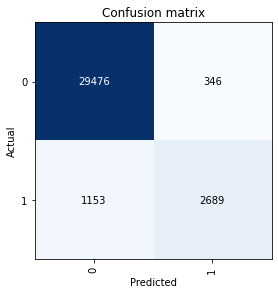

In [0]:
preds,y,losses = learn_clas.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn_clas, preds, y, losses)
interp.plot_confusion_matrix()

In [0]:
learn_clas.predict("i hope you have a good day!")

(Category 0, tensor(0), tensor([0.9828, 0.0172]))

In [0]:
learn_clas.predict("kanasai")

(Category 0, tensor(0), tensor([0.9716, 0.0284]))